In [2]:
!pip install gdown

#Download file training dan validasi dari Google Drive menggunakan file ID
!gdown --id 1oiBeWGLWatDOIj75J7MNP_EQmG_EPxek -O Dataset_pH_Bunga_Telang_Train.zip
!gdown --id 1l9ibha0S-l-36ZFR-rFkV7IftWoyR5uD -O Dataset_pH_Bunga_Telang_Validation.zip

#Ekstrak file zip
!unzip -q Dataset_pH_Bunga_Telang_Train.zip -d ./train_data
!unzip -q Dataset_pH_Bunga_Telang_Validation.zip -d ./validasi_data

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oiBeWGLWatDOIj75J7MNP_EQmG_EPxek
From (redirected): https://drive.google.com/uc?id=1oiBeWGLWatDOIj75J7MNP_EQmG_EPxek&confirm=t&uuid=a27d9f07-f843-4d48-85ba-a5ee25eb7ded
To: /content/Dataset_pH_Bunga_Telang_Train.zip
100% 428M/428M [00:07<00:00, 56.3MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1l9ibha0S-l-36ZFR-rFkV7IftWoyR5uD
From (redirected): https://drive.google.com/uc?id=1l9ibha0S-l-36ZFR-rFkV7IftWoyR5uD&confirm=t&uuid=78543b61-6772-4475-bc51-a8cf02d3807d
To: /c

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ConvNextConfig, ConvNextModel
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import cv2
import os

device = "cuda" if torch.cuda.is_available() else "cpu"



### Preprocessing Dataset

In [12]:
import random
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [13]:
# Path dataset
train_path = '/content/train_data/Dataset_pH_Bunga_Telang_Train'
validasi_path = '/content/validasi_data/Dataset_pH_Bunga_Telang_Validation'

# Mean & std (dari datasetmu)
RGB_mean = [0.2757323, 0.28446444, 0.33513261]
RGB_std = [0.21059035, 0.2042752, 0.22735262]

# Transformasi untuk training (augment + normalize)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.16),  # mirip tf.image.random_brightness
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_mean, std=RGB_std)
])

# Transformasi untuk validasi (hanya resize + normalize)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_mean, std=RGB_std)
])

# Dataset
train_ds = datasets.ImageFolder(root=train_path, transform=train_transforms)
val_ds = datasets.ImageFolder(root=validasi_path, transform=val_transforms)

# DataLoader
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Class names
class_names = train_ds.classes
print(f"Classes: {class_names}")

Classes: ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']


### Model Architecture

In [14]:
Model_ID = "facebook/convnext-tiny-224"
config = ConvNextConfig.from_pretrained(Model_ID)
config.hidden_dropout_prob = 0.0
convnext_backbone = ConvNextModel.from_pretrained(Model_ID, config=config)

# Unfreeze all layers
for param in convnext_backbone.parameters():
    param.requires_grad = True

In [15]:
class ConvNextClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        hidden_size = backbone.config.hidden_sizes[-1] # ConvNeXT tiny hidden size = 768
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        outputs = self.backbone(x)
        pooled = outputs.pooler_output
        return self.classifier(pooled)

num_classes = len(train_ds.classes)
model = ConvNextClassifier(convnext_backbone, num_classes).to(device)

### Model Training

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

In [17]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

EPOCHS = 15

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss, train_correct = 0, 0

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_ds)
    train_acc = train_correct / len(train_ds)

    # Simpan metrik pelatihan
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Eval
    model.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    test_loss /= len(val_ds)
    test_acc = test_correct / len(val_ds)

    # Simpan metrik validasi
    val_losses.append(test_loss)
    val_accs.append(test_acc)

    print(f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={test_loss:.4f}, Val Acc={test_acc:.4f}")

Epoch 1 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=2.4102, Train Acc=0.1853, Val Loss=2.2964, Val Acc=0.3172


Epoch 2 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=2.0600, Train Acc=0.4737, Val Loss=1.7887, Val Acc=0.5950


Epoch 3 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=1.4807, Train Acc=0.6841, Val Loss=1.1984, Val Acc=0.7263


Epoch 4 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.9791, Train Acc=0.7537, Val Loss=0.8198, Val Acc=0.7636


Epoch 5 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.7122, Train Acc=0.7937, Val Loss=0.6431, Val Acc=0.7961


Epoch 6 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.5692, Train Acc=0.8171, Val Loss=0.5324, Val Acc=0.8286


Epoch 7 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d22265d5a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d22265d5a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss=0.4684, Train Acc=0.8570, Val Loss=0.4515, Val Acc=0.8625


Epoch 8 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.3955, Train Acc=0.8816, Val Loss=0.3897, Val Acc=0.8811


Epoch 9 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.3298, Train Acc=0.9034, Val Loss=0.3395, Val Acc=0.9053


Epoch 10 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.2727, Train Acc=0.9287, Val Loss=0.3008, Val Acc=0.9136


Epoch 11 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.2242, Train Acc=0.9441, Val Loss=0.2677, Val Acc=0.9233


Epoch 12 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.1886, Train Acc=0.9524, Val Loss=0.2435, Val Acc=0.9274


Epoch 13 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.1537, Train Acc=0.9685, Val Loss=0.2215, Val Acc=0.9371


Epoch 14 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.1216, Train Acc=0.9773, Val Loss=0.1966, Val Acc=0.9426


Epoch 15 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.0984, Train Acc=0.9837, Val Loss=0.1811, Val Acc=0.9482


### Model Evaluation

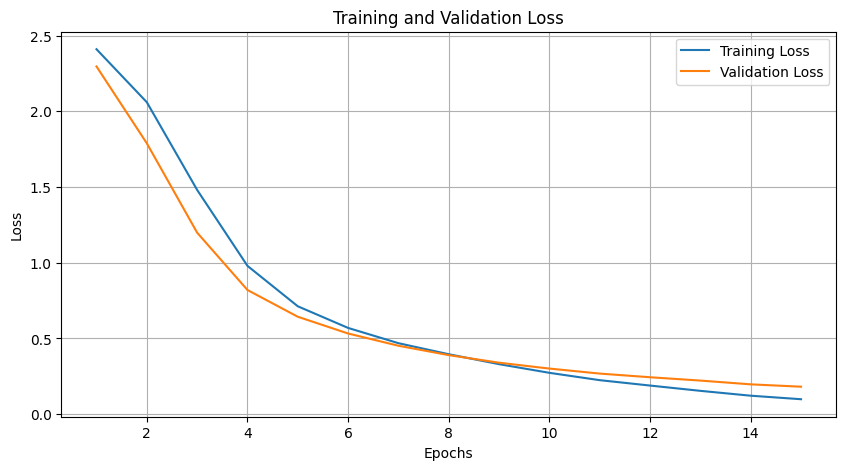

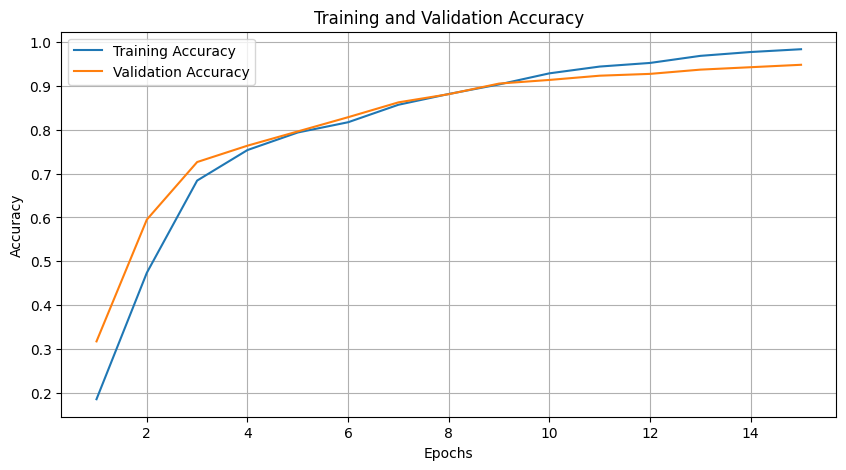

In [22]:
epochs_range = range(1, EPOCHS + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.plot(epochs_range, val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()

Making Predictions...:   0%|          | 0/12 [00:00<?, ?it/s]

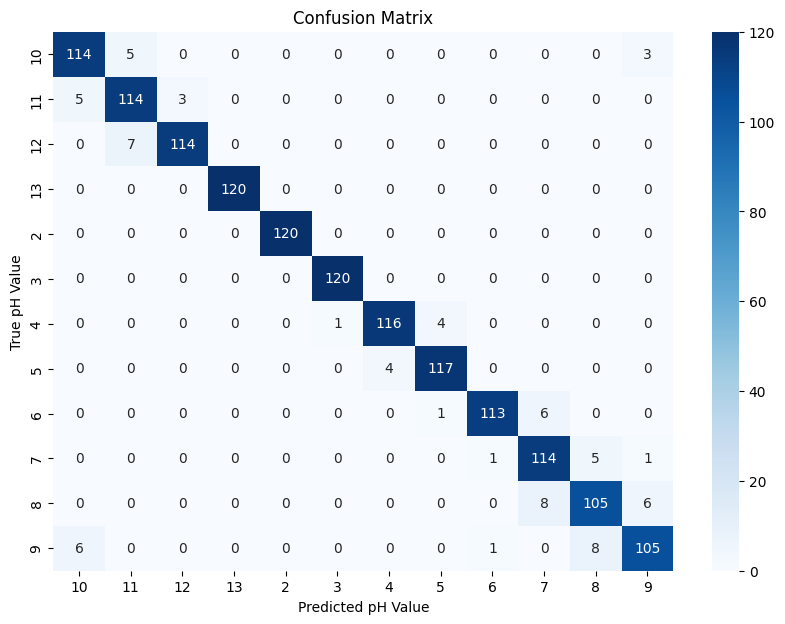

Classification Report:
               precision    recall  f1-score   support

          10       0.91      0.93      0.92       122
          11       0.90      0.93      0.92       122
          12       0.97      0.94      0.96       121
          13       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       0.99      1.00      1.00       120
           4       0.97      0.96      0.96       121
           5       0.96      0.97      0.96       121
           6       0.98      0.94      0.96       120
           7       0.89      0.94      0.92       121
           8       0.89      0.88      0.89       119
           9       0.91      0.88      0.89       120

    accuracy                           0.95      1447
   macro avg       0.95      0.95      0.95      1447
weighted avg       0.95      0.95      0.95      1447



In [23]:
model.eval()
pred_test = []
true_test = []

with torch.inference_mode():
    for X_batch, y_batch in tqdm(val_dataloader, desc="Making Predictions..."):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        logits = model(X_batch)
        preds = torch.softmax(logits, dim=1).argmax(dim=1)
        pred_test.append(preds.cpu())
        true_test.append(y_batch.cpu())

# concatenate into two long 1D tensors
pred_test = torch.cat(pred_test, dim=0).numpy() # (N_total_samples,)
true_test = torch.cat(true_test, dim=0).numpy() # (N_total_samples,)

# Compute and plot confusion matrix
cm = confusion_matrix(true_test, pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted pH Value")
plt.ylabel("True pH Value")
plt.title("Confusion Matrix")
plt.show()

# Classification report-
report = classification_report(true_test, pred_test, target_names=class_names)
print("Classification Report:\n", report)


### Model Save

In [28]:
# Save the Model
torch.save(model.state_dict(),"ConvNeXT_best_model.pth")